<a href="https://colab.research.google.com/github/collinfinnan/Testing/blob/main/Update3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the needed packages

In [32]:
import cv2
import numpy as np
import tensorflow as tf
from skimage import measure
from skimage import feature
from sys import platform as sys_pf
import warnings
import scipy as scipy
from scipy.stats import norm
from google.colab import drive
from google.colab.patches import cv2_imshow
warnings.filterwarnings("ignore")
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import torch
from sklearn import svm

if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

Mount the drive and load the image in as greyscale

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Enter the name of the image: test_numbers.jpg


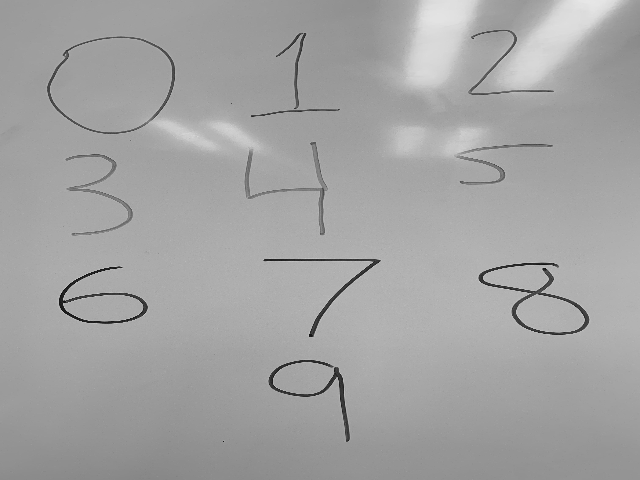

In [46]:
drive.mount('/content/gdrive')

file = input('Enter the name of the image: ')
path = '/content/gdrive/My Drive/Colab Notebooks/Test Images/' + file
sample_grey = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Display
sample_small = cv2.resize(sample_grey, (640, 480))
cv2_imshow(sample_small)
cv2.waitKey(0)
cv2.destroyAllWindows()

Find the gaussian fit for the image and use it to define the threshold for binariziation

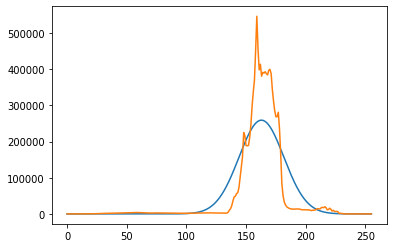

In [47]:
data = sample_grey.ravel()
mu, sigma = norm.fit(data)
x = np.linspace(0, 255, 10**4)
y = len(data) * norm.pdf(x, mu, sigma)
plt.plot(x, y)
hist, bin_edges = np.histogram(data, bins=256, range=(0,255))
plt.plot(hist)
plt.show()

Binarize the image

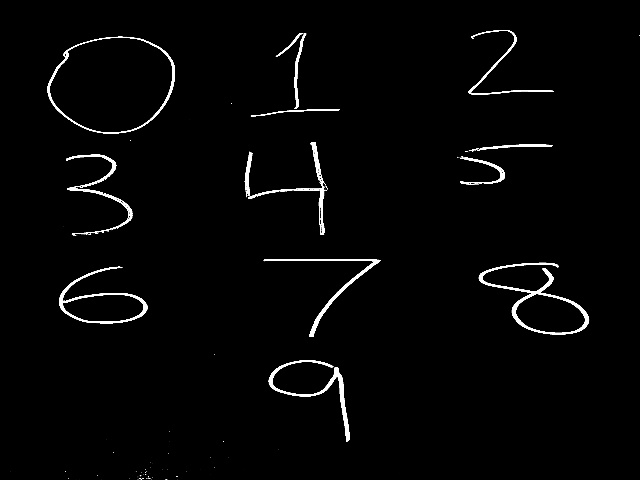

In [48]:
thresh_value = mu - 1.5 * sigma
ret1, binary_image = cv2.threshold(src=sample_grey, thresh=thresh_value, maxval=255, type=cv2.THRESH_BINARY)
binary_image = cv2.bitwise_not(binary_image)

# Display 
sample_small = cv2.resize(binary_image, (640, 480))
cv2_imshow(sample_small)
cv2.waitKey(0)
cv2.destroyAllWindows()

Use morphological operators to better define the number boundaries

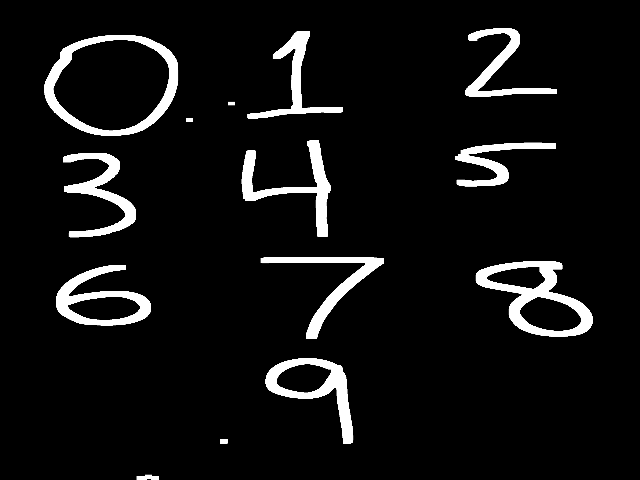

In [71]:
# Use MORPH_OPEN to remove white dots 
kernel = np.ones((3, 3),np.uint8)
segment_binary = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Fill in any gaps using MORPH_CLOSE
kernel = np.ones((40, 40),np.uint8)
segment_binary = cv2.morphologyEx(segment_binary, cv2.MORPH_CLOSE, kernel)

# Dilate the image to make features larger / more detectable
kernel = np.ones((3, 3),np.uint8)
segment_binary = cv2.dilate(segment_binary, kernel, iterations = 15)

# Display image after morphological orerators
sample_small = cv2.resize(segment_binary, (640, 480))
cv2_imshow(sample_small)
cv2.waitKey(0)
cv2.destroyAllWindows()

Find and define the edges of each number and insert into a list

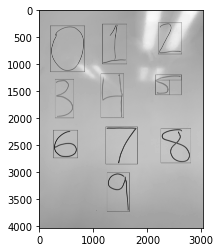

In [72]:
contours,_ = cv2.findContours(segment_binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
preprocessed_digits = []
for c in contours:

  if cv2.contourArea(c) < 5000:
    continue

  x,y,w,h = cv2.boundingRect(c)
  cv2.rectangle(sample_grey, (x,y), (x+w, y+h), color=(0,255,0), thickness=2)
  digit = segment_binary[y:y+h, x:x+w]
  resize_digit = cv2.resize(digit, (18,18))
  padded_digit = np.pad(resize_digit, ((5,5), (5,5)), "constant", constant_values=0)
  preprocessed_digits.append(padded_digit)

plt.imshow(sample_grey, cmap="gray")
inp = np.array(preprocessed_digits)

Load MNIST data

In [51]:
# Load in the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape it to work with Keras API
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

# Define the train classes for the SVM 
train_class = y_train
test_class = y_test

# Change classes to one-hot for the Keras API
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Code to create and train a CNN (do not need to run if model is already defined)

Epoch 1/3
1875/1875 [==============================] - 132s 70ms/step - loss: 0.4076 - accuracy: 0.9519 - val_loss: 0.0902 - val_accuracy: 0.9752
Epoch 2/3
1875/1875 [==============================] - 131s 70ms/step - loss: 0.0709 - accuracy: 0.9792 - val_loss: 0.1088 - val_accuracy: 0.9690
Epoch 3/3
1875/1875 [==============================] - 131s 70ms/step - loss: 0.0477 - accuracy: 0.9855 - val_loss: 0.0921 - val_accuracy: 0.9721
Prediction (Softmax) from the neural network:

 [[9.9997449e-01 3.0529312e-10 6.6667021e-06 3.7037775e-09 6.4426325e-11
  6.5592204e-08 1.8546702e-05 3.5245847e-12 4.5331728e-08 2.7905811e-08]]


Hard-maxed form of the prediction: 

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


--------- Prediction --------- 




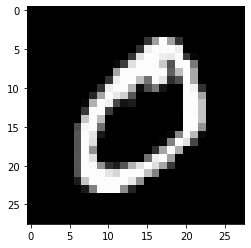



Final Output: 0


In [14]:
# Declare the model
model = Sequential()

# Create the layers (we used two conv2d layers each with more filters)
layer_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1))
layer_2 = Conv2D(64, kernel_size=3, activation='relu')
layer_3 = Flatten()
layer_4 = Dense(10, activation='softmax')

# Add the layers to the model
model.add(layer_1)
model.add(layer_2)
model.add(layer_3)
model.add(layer_4)

# Compile the model and train it (our optimizer was a built in one)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

# Provide some example tests
example = X_train[1]
prediction = model.predict(example.reshape(1, 28, 28, 1))

# First output
print ("Prediction (Softmax) from the neural network:\n\n {}".format(prediction))

# Second output
hard_maxed_prediction = np.zeros(prediction.shape)
hard_maxed_prediction[0][np.argmax(prediction)] = 1
print ("\n\nHard-maxed form of the prediction: \n\n {}".format(hard_maxed_prediction))

# Third output
print ("\n\n--------- Prediction --------- \n\n")
plt.imshow(example.reshape(28, 28), cmap="gray")
plt.show()
print("\n\nFinal Output: {}".format(np.argmax(prediction)))

Save the model to drive

In [52]:
path = '/content/gdrive/My Drive/Colab Notebooks/cnnmodel.tf'
model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/cnnmodel.tf/assets


Load the model and test is on the preprocessed images

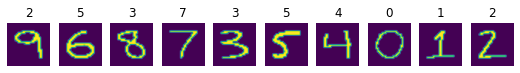

In [73]:
# Load model 
path = '/content/gdrive/My Drive/Colab Notebooks/'
new_model = tf.keras.models.load_model(path + 'cnnmodel.tf')

# Create figure
fig = plt.figure(figsize=(10, 7))
  
# Setting values to rows and column variables
rows = 1
columns = len(preprocessed_digits) + 1

# Predict and print each image
for i in range(len(preprocessed_digits)):

  prediction = new_model.predict(preprocessed_digits[i].reshape(1, 28, 28, 1)).argmax()
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(cv2.resize(preprocessed_digits[i].reshape(28,28), (280,280)))
  plt.axis('off')
  plt.title(prediction)

plt.show()

Normalize the preprocessed images to be used in LBP recognition

In [16]:
# Now prepare the data for LBP and SVM 
X_train = X_train.reshape((len(X_train),28,28)).astype('float32')
X_test = X_test.reshape((len(X_test),28,28)).astype('float32')
for i in range(len(preprocessed_digits)):
  preprocessed_digits[i] = preprocessed_digits[i].astype('float32')
  preprocessed_digits[i] /= 255

X_train /= 255
X_test /= 255

Take LBP of these newly normalized images

In [17]:
numPoints = 8
radius = 1
bins = 59

# Take the LBP of the preprocessed images
my_data = np.empty([len(preprocessed_digits), bins])
for i in range(len(my_data)):
  lbp = feature.local_binary_pattern(preprocessed_digits[i], numPoints, radius, method='nri_uniform')
  (hist, _) = np.histogram(lbp.ravel(), bins = bins)
  hist = hist.astype("float")
  my_data[i] = hist

# Of the training data
train_data = np.empty([len(X_train), bins])
for i in range(len(X_train)):
  lbp = feature.local_binary_pattern(X_train[i], numPoints, radius, method='nri_uniform')
  (hist, _) = np.histogram(lbp.ravel(), bins = bins)
  hist = hist.astype("float")
  train_data[i] = hist

# Of the testing data
test_data = np.empty([len(X_test), bins])
for i in range(len(X_test)):
  lbp = feature.local_binary_pattern(X_test[i], numPoints, radius, method='nri_uniform')
  (hist, _) = np.histogram(lbp.ravel(), bins = bins)
  hist = hist.astype("float")
  test_data[i] = hist

Normalize the LBP data

In [18]:
# Initialize arrays
means = np.empty(bins)
stds = np.empty(bins)

# Calculate the mean and std of each direction in 59-dim space
for i in range(bins):
  means[i] = train_data[:,i].mean()
  stds[i] = train_data[:,i].std()

# Normalize all 3 datasets
for i in range(len(train_data)):
  train_data[i,:] = (train_data[i,:] - means) / stds

for i in range(len(test_data)):
  test_data[i,:] = (test_data[i,:] - means) / stds

for i in range(len(my_data)):
  my_data[i,:] = (my_data[i,:] - means) / stds

Create the SVM models

In [ ]:
# Create rbf classifier
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf', gamma='auto')
clf.fit(train_data, train_class)
model_name = 'classifier_rbf.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
torch.save(clf, path)

# Create linear classifier
clf = svm.SVC(decision_function_shape='ovo', kernel='linear', gamma='auto')
clf.fit(train_data, train_class)
model_name = 'classifier_linear.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
torch.save(clf, path)

# Create poly classifier
clf = svm.SVC(decision_function_shape='ovo', kernel='poly', gamma='auto')
clf.fit(train_data, train_class)
model_name = 'classifier_poly.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
torch.save(clf, path)

Test the SVM Model on the Training Data (Data it has seen before)

In [24]:
# Test the linear classifer
model_name = 'classifier_linear.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf= torch.load(path)

num = 0
for i in range(len(train_data)):
  if clf.predict([train_data[i]])[0] == train_class[i]:
    num = num + 1

accuracy = num / len(train_data)
print('Accuracy of testing data for linear classifier:')
print(accuracy)
print(num)

# Test the poly classifier
model_name = 'classifier_poly.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf= torch.load(path)

num = 0
for i in range(len(train_data)):
  if clf.predict([train_data[i]])[0] == train_class[i]:
    num = num + 1

accuracy = num / len(test_data)
print('Accuracy of testing data for poly classifier:')
print(accuracy)
print(num)

# Test the RBF classifier
model_name = 'classifier_rbf.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf= torch.load(path)

num = 0
for i in range(len(train_data)):
  if clf.predict([train_data[i]])[0] == train_class[i]:
    num = num + 1

accuracy = num / len(test_data)
print('Accuracy of testing data for rbf classifier:')
print(accuracy)
print(num)

Accuracy of testing data for linear classifier:
0.6944333333333333
41666
Accuracy of testing data for poly classifier:
5.0486
50486
Accuracy of testing data for rbf classifier:
5.0746
50746


Test the SVM Model on the testing data

In [23]:
# Test the linear classifer
model_name = 'classifier_linear.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf= torch.load(path)

num = 0
for i in range(len(test_data)):
  if clf.predict([test_data[i]])[0] == test_class[i]:
    num = num + 1

accuracy = num / len(test_data)
print('Accuracy of testing data for linear classifier:')
print(accuracy)

# Test the poly classifier
model_name = 'classifier_poly.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf= torch.load(path)

num = 0
for i in range(len(test_data)):
  if clf.predict([test_data[i]])[0] == test_class[i]:
    num = num + 1

accuracy = num / len(test_data)
print('Accuracy of testing data for poly classifier:')
print(accuracy)

# Test the RBF classifier
model_name = 'classifier_rbf.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf= torch.load(path)

num = 0
for i in range(len(test_data)):
  if clf.predict([test_data[i]])[0] == test_class[i]:
    num = num + 1

accuracy = num / len(test_data)
print('Accuracy of testing data for rbf classifier:')
print(accuracy)

Accuracy of testing data for linear classifier:
0.6828
Accuracy of testing data for poly classifier:
0.7449
Accuracy of testing data for rbf classifier:
0.7654


Load and test the models

In [ ]:
# Test the RBF classifier
model_name = 'classifier_rbf.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_name}"
clf = torch.load(path)
for i in range(len(my_data)):
  print(clf.predict([my_data[i]])[0])
  cv2_imshow(preprocessed_digits[i] * 255)

7


1


0


2


7


3


1


0
